In [1]:
from pathlib import Path

name = "librispeech-dev-clean"
in_dir = Path("data/dev-clean")
align_dir = Path("data/alignments/dev-clean")
feat_dir = Path("features")
audio_ext = ".flac" 

In [7]:
from encode import sample_files, count_number_of_utterances_for_features
from utils.features import DataSet

dataset = DataSet(
    name, in_dir, align_dir, feat_dir, audio_ext 
)

sample_size = -1
gamma = 0.2

out_dir_dusted = Path(f"output/dusted/{sample_size}")
if sample_size < 0:
    out_dir_dusted = Path("output/dusted/all")

sampled_paths = sample_files(dataset, sample_size, True)
# Store a dictionary with indices and paths 
sample_size = len(sampled_paths)
print(sample_size)
print(count_number_of_utterances_for_features(sampled_paths))

63137
2703


In [9]:
from encode import get_units


sampled_paths = sample_files(dataset, -1)
print(sampled_paths)
# get_units(dataset, "dusted", sampled_paths, gamma=0.2, layer=7,  save=True)

[PosixPath('data/dev-clean/2412/153954/2412-153954-0019.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0023.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0015.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0003.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0002.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0014.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0022.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0018.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0013.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0005.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0009.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0024.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0008.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0004.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0012.flac'), PosixPath('data/dev-clean/2412/153954/2412-153954-0007

In [3]:
LOGGING = False

def log(message):
    if LOGGING:
        print(message)

In [ ]:
import pandas as pd
from pathlib import Path
from utils.features import load_word
import time 
from distance import calculate_distance_per_chunk
from joblib import Parallel, delayed

def preload_npy_files(model_path):
    """Preload .npy file paths into a dictionary for fast lookups."""
    return {path.stem: path for path in model_path.rglob("*.npy")}

def process_key(key, file_map, words_cache, keys, align_df):
    """Helper function to process a single key."""
    if key in words_cache:
        return words_cache[key]  # Retrieve from cache
    
    path = file_map.get(key)
    if path is None:
        print(f"Warning: No file found for key '{key}' in file_map")
        return None  # Skip processing for missing files

    word = load_word(path, key, align_df)  # Load word
    words_cache[key] = word  # Cache it
    keys.add(key)
    return word

def load_units_for_chunk(dataset, model, chunk, gamma=None, align_df=None, file_map=None, n_jobs=-1):
    """Optimized function for loading units for a chunk with parallel loading using joblib."""

    # Use Parquet if available for faster reading
    if align_df is None:
        csv_path = dataset.align_dir / "alignments.csv"
        if csv_path.with_suffix(".parquet").exists():
            align_df = pd.read_parquet(csv_path.with_suffix(".parquet"))
        else:
            align_df = pd.read_csv(csv_path)

    # Determine model path
    model_path = dataset.feat_dir / f"{model}_units"
    if gamma:
        model_path /= str(gamma)

    # Preload file paths if not provided
    file_map = file_map or preload_npy_files(model_path)
    print(file_map)
    words_cache = {}  # Cache for fast word retrieval
    keys = set()
    chunk_words = []

    # Process words in parallel using joblib
    for pair in chunk:
        pair_keys = tuple(pair.keys())
        words = Parallel(n_jobs=n_jobs)(
            delayed(process_key)(key, file_map, words_cache, keys, align_df) for key in pair_keys
        )
        chunk_words.append(tuple(words))

    return chunk_words



def process_chunk(chunk, sampled_paths, dataset, gamma):
    start_time = time.perf_counter()

    chunk_paths = [{i: sampled_paths[i], j: sampled_paths[j]} for i, j in chunk]
    align_df = pd.read_csv(dataset.align_dir / "alignments.csv")

    load_chunk_start = time.perf_counter()
    chunk_words = load_units_for_chunk(
        dataset, "dusted", chunk_paths, gamma=gamma, align_df=align_df
    )
    load_chunk_end = time.perf_counter()
    print(f"load_chunk execution time: {load_chunk_end - load_chunk_start:.4f} sec")

    chunk_result = calculate_distance_per_chunk(chunk_words)

    end_time = time.perf_counter()
    print(f"process_chunk execution time: {end_time - start_time:.4f} sec")
    return chunk_result, chunk_words



In [11]:
import torch
import numpy as np
from utils.extract import get_batch_of_paths
# from distance import process_chunk, store_words_for_chunk
from distance import store_words_for_chunk
from tqdm import tqdm

dist_mat = torch.zeros((sample_size, sample_size), dtype=torch.float32)
distances = []
start_time = time.perf_counter()


chunk_limit = 1000
num_pairs = len(sampled_paths) * (len(sampled_paths) - 1) // 2
print(num_pairs)
num_chunks = (num_pairs + chunk_limit - 1) // chunk_limit 
print(num_chunks)

word_csv_path = "output/dusted/words.csv"
out_path = Path("output/dusted/dist_mat.npz")
out_path.parent.mkdir(parents=True, exist_ok=True)


words = []

for chunk in tqdm(get_batch_of_paths(len(sampled_paths), chunk_limit), total=num_chunks, desc="Processing Chunks"):
    chunk_result = process_chunk(chunk, sampled_paths, dataset, gamma)
    res_start_time = time.perf_counter()
    for res in chunk_result[0]:
        dist_mat[res[0], res[1]] = res[2]
    res_end_time = time.perf_counter()
    print(f"Chunk results execution time: {res_end_time - res_start_time:.4f} sec")
    words.extend(chunk_result[1])
    break


store_words_for_chunk(words, word_csv_path)
np.savez_compressed(out_path, dist_mat.numpy())

end_time = time.perf_counter()
print(f"Total execution time: {end_time - start_time:.4f} sec")

    

3651753
3652


Processing Chunks:   0%|          | 0/3652 [00:00<?, ?it/s]

Processing Chunks:   0%|          | 0/3652 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from encode import get_units
from joblib import Parallel, delayed

results = Parallel(n_jobs=2)([
    delayed(get_units)(dataset, "dusted", sampled_paths, gamma, True),  
])
dusted_words = results[0]


Using cache found in /Users/daneladendorff/.cache/torch/hub/bshall_dusted_main
Using cache found in /Users/daneladendorff/.cache/torch/hub/bshall_dusted_main
Using cache found in /Users/daneladendorff/.cache/torch/hub/bshall_hubert_main
Getting units:   0%|          | 0/63137 [00:00<?, ?it/s]


RuntimeError: torchaudio_sox::load_audio_file() Expected a value of type 'str' for argument '_0' but instead found type 'PosixPath'.
Position: 0
Value: PosixPath('features/dusted_units/0.2/2412/153954/2412-153954-0009_1.npy')
Declaration: torchaudio_sox::load_audio_file(str _0, int? _1, int? _2, bool? _3, bool? _4, str? _5) -> (Tensor _0, int _1)
Cast error details: Unable to cast Python instance of type <class 'pathlib.PosixPath'> to C++ type '?' (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)

In [ ]:
from utils.features import load_units_from_paths
from joblib import Parallel, delayed

results = Parallel(n_jobs=2)([
    delayed(load_units_from_paths)(dataset, "dusted", sampled_paths, gamma=0.2),  
])

dusted_words = results[0]

Loading Units: 100%|██████████| 2703/2703 [06:28<00:00,  6.96it/s]


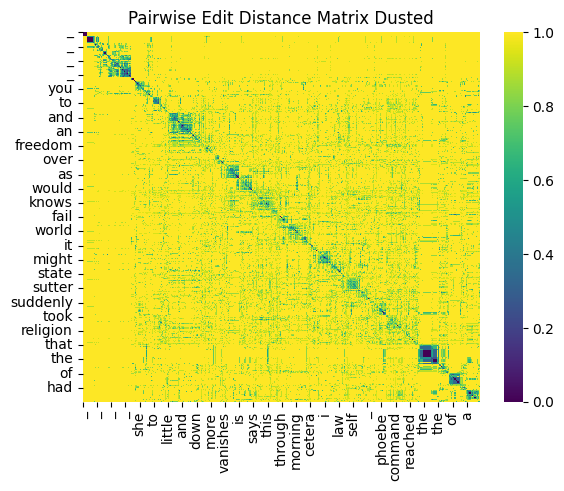

In [ ]:
from eval import pairwise_edit_dist_mat

# Visualise the distances
pairwise_edit_dist_mat(dist_mat_dusted, "Pairwise Edit Distance Matrix Dusted", true_words)

In [ ]:
from cluster import cluster, get_word_clusters

# Get the int_clusters for each of the matrices
dust_clusters = cluster(dist_mat_dusted, 0.2)

# Convert these to word clusters
dust_word_clusters = get_word_clusters(dust_clusters, dusted_words)

Getting Word Clusters: 100%|██████████| 4909/4909 [00:02<00:00, 2343.80it/s]


In [ ]:
from cluster import get_loaded_clusters

dust_word_clusters = get_loaded_clusters(dusted_words)

In [ ]:
from eval import ned

# Compute the ned for my dusted and hubert clusters - atm my NED is computed only using clusters with > 1 words
ned_dusted = ned(dust_word_clusters, print_pure=False, print_inpure=True)
print(f"DUSTED NED: {ned_dusted}")

Calculating NED: 100%|██████████| 4909/4909 [00:00<00:00, 292527.47it/s]

Cluster 9: 0.047244094488188976
the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, a, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the

Cluster 14: 0.8
then, then, then, men, then

Cluster 22: 1
and, and, in, an, and

Cluster 39: 0.45789473684210524
in, in, in, in, in, in, in, in, in, and, in, in, and, in, in, an, in, in, in, in

Cluster 42: 0.09781420765027322
the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, th

In [ ]:
from cluster import get_best_clusters

ned_dusted, duplicate_count_dusted, dust_word_clusters = get_best_clusters(dust_word_clusters, ned_dusted, max_iter=5)

Iteration 0: NED: 0.061213, Duplicates: 3183


Calculating NED: 100%|██████████| 4909/4909 [00:00<00:00, 532505.00it/s]


Iteration 1: NED: 0.061804


Calculating NED: 100%|██████████| 4909/4909 [00:00<00:00, 531858.51it/s]


Iteration 2: NED: 0.060975


Calculating NED: 100%|██████████| 4909/4909 [00:00<00:00, 536626.92it/s]


Iteration 3: NED: 0.061163


Calculating NED: 100%|██████████| 4909/4909 [00:00<00:00, 522253.35it/s]


Iteration 4: NED: 0.060921


Calculating NED: 100%|██████████| 4909/4909 [00:00<00:00, 535287.62it/s]

Iteration 5: NED: 0.060741
Best NED: 0.060741, Best Duplicates: 3168


In [ ]:
from utils.features import store_words

# Store words associated with these clusters
store_words(dust_word_clusters, out_dir_dusted)

Wrote words to output/dusted/300/words.csv


In [ ]:
from eval import words_from_word_units, clusters_purity
            
dust_just_words_clusters = words_from_word_units(dust_word_clusters)
inpurity, total = clusters_purity(dust_just_words_clusters)
print(f"{total} Dusted Clusters with inpurity: {round(inpurity*100, 3)}%")

4909 Dusted Clusters with inpurity: 59.747%


In [ ]:
from eval import calculate_duplicate_clusters

cluster_counts_dusted, duplicate_counts_dusted = calculate_duplicate_clusters(dust_word_clusters, print_clusters=True)

Total duplicate clusters (considering word frequency): 3168
Duplicate clusters and their counts:
{'three': 1}: 4 times
{'into': 1}: 8 times
{'_': 9}: 5 times
{'of': 3}: 5 times
{'_': 1}: 213 times
{'delightful': 1}: 2 times
{'song': 1}: 2 times
{'of': 5}: 3 times
{'bird': 1}: 2 times
{'that': 1}: 50 times
{'have': 1}: 19 times
{'the': 4}: 2 times
{'and': 1}: 113 times
{'and': 2}: 13 times
{'turn': 1}: 2 times
{'other': 1}: 9 times
{'is': 1, 'his': 1}: 2 times
{'do': 1}: 9 times
{'side': 1}: 6 times
{'it': 1}: 43 times
{'near': 1}: 5 times
{'fire': 1}: 3 times
{'it': 2}: 3 times
{'place': 1}: 3 times
{'then': 1}: 9 times
{'until': 1}: 2 times
{'that': 2}: 5 times
{'so': 1}: 5 times
{'not': 1}: 9 times
{'and': 4}: 3 times
{'feature': 1}: 2 times
{'worth': 1}: 3 times
{'serve': 1}: 2 times
{'much': 1}: 4 times
{'how': 1}: 6 times
{'_': 2}: 55 times
{'the': 5}: 2 times
{'on': 1}: 14 times
{'in': 2, 'and': 1}: 2 times
{'is': 1}: 19 times
{'little': 1}: 5 times
{'but': 1}: 43 times
{'they': 

In [ ]:
def save_cluster_centroids(centroids, dir):
    out_path = Path(dir) / "centroids.csv"
    centroid_df = pd.DataFrame(columns=["id", "text", "units"])
    for c in range(len(centroids)):
        
        new_row = pd.DataFrame(
            [[c, centroids[c].true_word, centroids[c].clean_encoding]],
            columns=centroid_df.columns,
        )
        centroid_df = pd.concat([centroid_df, new_row], ignore_index=True)
    centroid_df.to_csv(out_path, index=False)
    print(f"Wrote centroids to {out_path}")


In [ ]:
from cluster import get_cluster_centroids

centroids = get_cluster_centroids(dust_word_clusters)
save_cluster_centroids(centroids, out_dir_dusted)

Calculating Cluster Centroids: 100%|██████████| 4909/4909 [00:00<00:00, 21730.95it/s]


Wrote centroids to output/dusted/300/centroids.csv


In [ ]:
from encode import sample_files
from utils.features import load_units_from_paths
from encode import get_units
from cluster import get_distance_to_centroids, get_cluster_centroids
import editdistance
import statistics

query_path = sample_files(dataset, sample_size=1)

# Query one of the ladys
# query_path = [Path("data/dev-clean/174/50561/174-50561-0013.flac")]

query_dusted_words = load_units_from_paths(dataset, "dusted", query_path, gamma=0.2)
if not query_dusted_words:
    query_dusted_words = get_units(dataset, "dusted", query_path, gamma=0.2, save=True)
query_dusted_sentence = " ".join([w.true_word for w in query_dusted_words])

dust_centroids = get_cluster_centroids(dust_word_clusters)
query_dusted_words = get_distance_to_centroids([query_dusted_words], dust_centroids)


predictions = []
query_distances = []
for word in query_dusted_words:
    prediction = dust_centroids[word.cluster_id].true_word
    # print(" : ".join([word.true_word, prediction]))
    query_distances.append(editdistance.eval(word.true_word, prediction)/max(len(word.true_word), len(prediction)))
    predictions.append(prediction)

prediction_sentence = " ".join(predictions)
print(f"NED for query: {statistics.mean(query_distances)}")
print(query_dusted_sentence)
print(prediction_sentence)

Get Distances to Centroids: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]

NED for query: 0.175
the any there _ _ think you one is chance other for
the any their _ _ thing you one is pin other to
